Inverse Dynamics
===============
The `inversedynamics` calculates the proximal forces and moments based on the segment's kinematics and distal forces and moments, based on the general method published in:

!!! cite
    R. Dumas, R. Aissaoui, and J. A. De Guise, "A 3D generic inverse dynamic method using wrench notation and quaternion algebra,” Comput Meth Biomech Biomed Eng, vol. 7, no. 3, pp. 159–166, 2004.

The results are the forces and moments applied by the distal segment on the
proximal articulation, in the global coordinates system.

The state of this module is "Tested, but still not validated". To date, the following
tests were made and were successful:

1. A complete loop from the point of force application point to the force point application, using real wheelchair propulsion data, with a fake mass of 0 kg. In these test conditions, the proximal and distal kinetics are equal, as expected. This test was to verify that the implemented matrices are exempt of sign errors.
2. Real wheelchair propulsion data was inspected and seems plausible.

In [2]:
import ktk

Loading sample data
-------------------
In this tutorial, we will load propulsion data from a sprint in Wheelchair Basketball. Kinetics were recorded using an instrumented wheel (SmartWheel) and kinematics were recorded using an optoelectronic system (Optitrack). Data were preprocessed in Matlab.

In [3]:
# Total mass of the participant
total_mass = 75

# Load kinetics
kinetics = ktk.loadmat('data/inversedynamics/basketball_kinetics.mat')
kinetics = kinetics['kineticsSWR']

# Correct the signs so that the moments are in a correct coordinate system
# (The SmartWheel usually reports Mz positive when it should be negative)
kinetics.data['Moments'][:, 2] = -kinetics.data['Moments'][:, 2]

# Load kinematics
kinematics = ktk.loadmat('data/inversedynamics/basketball_kinematics.mat')
kinematics = kinematics['kinematics']
markers = kinematics['Markers']

# Sync kinetics and kinematics (there is a 5.525 time lag between both)
markers.time -= 5.525

# Merge all under the same ts_all TimeSeries.
ts_all = markers.copy()
ts_all.merge(kinetics, resample=True)

# Keep only the sprint data
ts_all = ts_all.get_ts_between_times(0, 15)

Calculate the force and moments at the hand
-------------------------------------------
The same calculation is done on every segment, from distal to proximal. We begin with the segment 'Wheel', since the kinetics are measured at the wheel, and we go up to the hand, which will later be the new point of force
application.

We will ignore the inertial parameters of the pushrim.

/Users/felix/Documents/Recherche/kineticstoolkit/ktk/filters.py:72: UserWarning: NaNs found in the signal. They have been interpolated before filtering, and then put back in the filtered data.
  warnings.warn(warning_message)


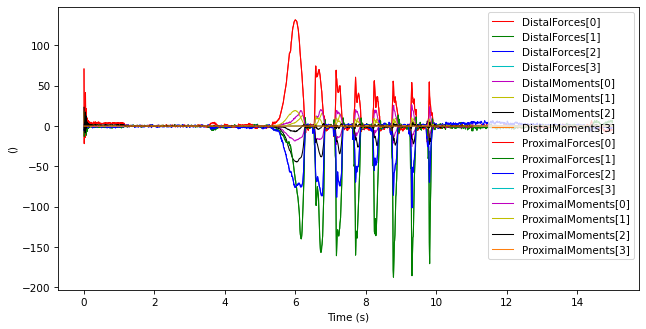

In [4]:
pushrim_inertial_parameters = {'Mass' : 0,
                               'COMProximalRatio' : 0,
                               'GyrationCOMRatio': 0}

ts = ktk.TimeSeries(time=ts_all.time)

ts.data['ProximalJointPosition'] = ts_all.data['BodyR_HandR']
ts.data['DistalJointPosition'] = ts_all.data['RearWheelCenterR']
ts.data['ForceApplicationPosition'] = ts_all.data['RearWheelCenterR']
ts.data['DistalForces'] = ts_all.data['Forces']
ts.data['DistalMoments'] = ts_all.data['Moments']

new_ts = ktk.inversedynamics.calculate_proximal_wrench(
        ts, pushrim_inertial_parameters)

# Print the results
new_ts.plot(['DistalForces', 'DistalMoments'])
new_ts.plot(['ProximalForces', 'ProximalMoments'])

Calculate the force and moments at the elbow
-------------------------------------------

/Users/felix/Documents/Recherche/kineticstoolkit/ktk/filters.py:72: UserWarning: NaNs found in the signal. They have been interpolated before filtering, and then put back in the filtered data.
  warnings.warn(warning_message)


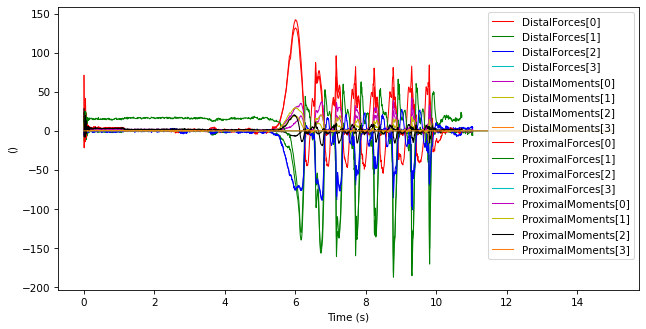

In [5]:
ts = ktk.TimeSeries(time=ts_all.time)

ts.data['ProximalJointPosition'] = ts_all.data['ElbowR']
ts.data['DistalJointPosition'] = ts_all.data['RadialStyloidR']
ts.data['ForceApplicationPosition'] = ts_all.data['BodyR_HandR']
ts.data['DistalForces'] = new_ts.data['ProximalForces']
ts.data['DistalMoments'] = new_ts.data['ProximalMoments']

new_ts = ktk.inversedynamics.calculate_proximal_wrench(
        ts, ktk.inversedynamics.get_anthropometrics('ForearmHand', total_mass))

# Print the results
new_ts.plot(['DistalForces', 'DistalMoments'])
new_ts.plot(['ProximalForces', 'ProximalMoments'])

Calculate the force and moments at the shoulder
--------------------------------------------

/Users/felix/Documents/Recherche/kineticstoolkit/ktk/filters.py:72: UserWarning: NaNs found in the signal. They have been interpolated before filtering, and then put back in the filtered data.
  warnings.warn(warning_message)


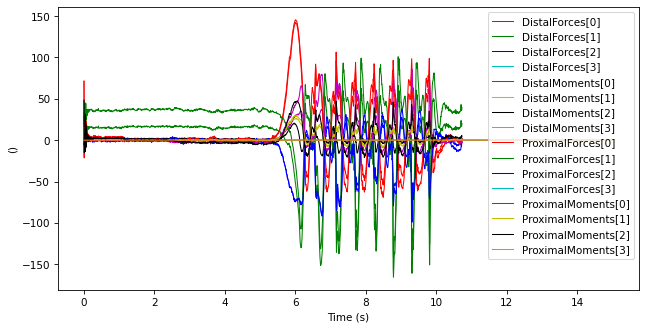

In [6]:
ts = ktk.TimeSeries(time=ts_all.time)

ts.data['ProximalJointPosition'] = ts_all.data['BodyR_AcromionR']
ts.data['DistalJointPosition'] = ts_all.data['ElbowR']
ts.data['ForceApplicationPosition'] = ts_all.data['ElbowR']
ts.data['DistalForces'] = new_ts.data['ProximalForces']
ts.data['DistalMoments'] = new_ts.data['ProximalMoments']

new_ts = ktk.inversedynamics.calculate_proximal_wrench(
        ts, ktk.inversedynamics.get_anthropometrics('UpperArm', total_mass))

# Print the results
new_ts.plot(['DistalForces', 'DistalMoments'])
new_ts.plot(['ProximalForces', 'ProximalMoments'])